# Real GDP annual growth with Hong Kong recessions 

This script downloads Hong Kong government produced quarterly statistics for nominal gross domestic product statistics and the gdp deflator. It then computes and graphs the real GDP annual growth over time. The source for the data is the Hong Kong census and statistics department and the data is downloaded from the government's application program interface (API). One advantage of using the API is that the script and produced chart should refresh with updated data as and when it is rerun. 

Let us get started by downloading the Python modules to be used.

In [12]:
import pandas as pd
import requests
import json
import os
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches # add shaded part as legend

Then download the [Table 310-31002 : Gross Domestic Product (GDP) by major expenditure component at current market price](https://www.censtatd.gov.hk/en/web_table.html?id=310-31002) from the government website.

In [13]:
url = "https://www.censtatd.gov.hk/api/post.php"
parameters ={
  "cv": {
    "GDP_COMPONENT": [
      "FD",
      "DD",
      "PCE",
      "GCE",
      "GDFCF",
      "CIV",
      "XGS",
      "MGS",
      "XG",
      "XS",
      "MG",
      "MS"
    ]
  },
  "sv": {
    "CUR": [
      "Raw_M_hkd_d"
    ]
  },
  "period": {
    "start": "197301"
  },
  "id": "310-31002",
  "lang": "en"
}
data = {'query': json.dumps(parameters)}

try:
    r = requests.post(url, data=data, timeout=20)
    r.raise_for_status()  # Raise an exception if the request was unsuccessful
except (requests.exceptions.HTTPError, requests.exceptions.RequestException) as err:
    print(f"An error occurred: {err}")
else:
    response_data = r.json()
    if response_data['header']['status']['name'] == 'Success':
        if response_data['dataSet']:
            df_gdp = pd.DataFrame(response_data['dataSet'])
            print(df_gdp)
        else:
            print("No data available")
    else:
        print(f"Request failed: {response_data['header']['status']['description']}")


     GDP_COMPONENT                   GDP_COMPONENTDesc freq  period   sv  \
0                                                Total    Y    1973  CUR   
1              CIV              Changes in inventories    Y    1973  CUR   
2               DD                     Domestic demand    Y    1973  CUR   
3               FD                        Final demand    Y    1973  CUR   
4              GCE  Government consumption expenditure    Y    1973  CUR   
...            ...                                 ...  ...     ...  ...   
3310            MS                 Imports of services    Q  202312  CUR   
3311           PCE     Private consumption expenditure    Q  202312  CUR   
3312            XG           Exports of goods (f.o.b.)    Q  202312  CUR   
3313           XGS       Exports of goods and services    Q  202312  CUR   
3314            XS                 Exports of services    Q  202312  CUR   

           svDesc   figure sd_value  
0     HK$ million    41327           
1     HK$ m

Tidy the data by extracting just the quarterly data, removing unwanted columns, and, renaming the date and data columns.

In [14]:
# from the dataframe remove all rows that do not contain "Total" in the GDP_COMPONTEDesc column
df_gdp = df_gdp[df_gdp['GDP_COMPONENTDesc'].str.contains('Total')]

# from the dataframe remove all rows that do not contain "Q" in the freq column
df_gdp = df_gdp[df_gdp['freq'].str.contains('Q')]

# keep wanted columns period and figure
df_gdp = df_gdp[['period', 'figure']]

# rename the period column "date" and make a datetime format from YYYYMM to YYYY-MM-DD
df_gdp = df_gdp.rename(columns={'period': 'date'})
df_gdp['date'] = pd.to_datetime(df_gdp['date'], format='%Y%m').dt.strftime('%Y-%m-%d')

# rename figure column to GDP_at_current_prices
df_gdp = df_gdp.rename(columns={'figure': 'GDP_at_current_prices_HKDMillions'})

In [15]:
print(df_gdp.info)

<bound method DataFrame.info of             date  GDP_at_current_prices_HKDMillions
13    1973-03-01                               9697
26    1973-06-01                               9586
39    1973-09-01                              10979
52    1973-12-01                              11064
78    1974-03-01                              11664
...          ...                                ...
3237  2022-12-01                             732062
3263  2023-03-01                             720760
3276  2023-06-01                             707502
3289  2023-09-01                             768426
3302  2023-12-01                             794640

[204 rows x 2 columns]>


Download the [Table 310-31001 : Gross Domestic Product (GDP), implicit price deflator of GDP and per capita GDP](https://www.censtatd.gov.hk/en/web_table.html?id=31) from the government website.

In [16]:
url = "https://www.censtatd.gov.hk/api/post.php"
parameters ={
  "cv": {},
  "sv": {
    "DEF": [
      "Raw_1dp_idx_n"
    ]
  },
  "period": {
    "start": "197301"
  },
  "id": "310-31001",
  "lang": "en"
}
data = {'query': json.dumps(parameters)}

try:
    r = requests.post(url, data=data, timeout=20)
    r.raise_for_status()  # Raise an exception if the request was unsuccessful
except (requests.exceptions.HTTPError, requests.exceptions.RequestException) as err:
    print(f"An error occurred: {err}")
else:
    response_data = r.json()
    if response_data['header']['status']['name'] == 'Success':
        if response_data['dataSet']:
            df_deflator = pd.DataFrame(response_data['dataSet'])
            print(df_deflator)
        else:
            print("No data available")
    else:
        print(f"Request failed: {response_data['header']['status']['description']}")

    freq  period   sv                 svDesc  figure sd_value
0      Y    1973  DEF  Index (Year 2021=100)    13.3         
1      Q  197303  DEF  Index (Year 2021=100)    12.7         
2      Q  197306  DEF  Index (Year 2021=100)    12.7         
3      Q  197309  DEF  Index (Year 2021=100)    13.6         
4      Q  197312  DEF  Index (Year 2021=100)    14.2         
..   ...     ...  ...                    ...     ...      ...
250    Y    2023  DEF  Index (Year 2021=100)   104.9        r
251    Q  202303  DEF  Index (Year 2021=100)   103.2        r
252    Q  202306  DEF  Index (Year 2021=100)   103.8        r
253    Q  202309  DEF  Index (Year 2021=100)   106.5        r
254    Q  202312  DEF  Index (Year 2021=100)   106.0        r

[255 rows x 6 columns]


Tidy the downloaded dataseries by: extracting just the quarterly data, removing unwanted columns, and, renaming the date and data columns.

In [17]:
# from the dataframe remove all rows that do not contain "Q" in the freq column
df_deflator = df_deflator[df_deflator['freq'].str.contains('Q')]

# keep wanted columns period and figure
df_deflator = df_deflator[['period', 'figure']]

# rename the period column "date" and make a datetime format from YYYYMM to YYYY-MM-DD
df_deflator = df_deflator.rename(columns={'period': 'date'})
df_deflator['date'] = pd.to_datetime(df_deflator['date'], format='%Y%m').dt.strftime('%Y-%m-%d')

# rename figure column to GDP_at_current_prices
df_deflator = df_deflator.rename(columns={'figure': 'GDP_deflator_index_yr2021_100'})


In [18]:
print(df_deflator.info)

<bound method DataFrame.info of            date  GDP_deflator_index_yr2021_100
1    1973-03-01                           12.7
2    1973-06-01                           12.7
3    1973-09-01                           13.6
4    1973-12-01                           14.2
6    1974-03-01                           14.4
..          ...                            ...
249  2022-12-01                          101.8
251  2023-03-01                          103.2
252  2023-06-01                          103.8
253  2023-09-01                          106.5
254  2023-12-01                          106.0

[204 rows x 2 columns]>


Merge the two dataframes together and compute the real GDP series by deflating the nominal GDP series values. And then from the real GDP series compute year on year annual changes for each quarter. 

In [19]:
# merge gdp data and gdp deflator
df = pd.merge(df_gdp, df_deflator, on='date')

# make date column datetime format YYYY-MM-DD
df['date'] = pd.to_datetime(df['date'])

# sort dataframe on date column in ascending order
df = df.sort_values(by='date', ascending=True)

# compute the GDP deflator index ratio using the formula calculate the ratio of the price index in 2021-12-31 to the price index in the current period.
# create a fresh column called gdp_deflator_ratio and make it 100/'GDP_deflator_index_yr2021_100'
df['gdp_deflator_ratio'] = 100 / df['GDP_deflator_index_yr2021_100']

# create a real_GDP column that is GDP_at_current_prices_HKDMillions * gdp_deflator_ratio
df['real_GDP'] = df['GDP_at_current_prices_HKDMillions'] * df['gdp_deflator_ratio']

# make date column datetime as a string (that removes time component of date format)
df['date'] = df['date'].dt.strftime('%Y-%m-%d')


# create columns that compute the year on year percentage change of GDP and real GDP
# the data is quarterly to ensure we are using the quarter from the previous year
# we use the formula ((current quarter - previous quarter) / previous quarter) * 100
df['real_GDP_yoy'] = ((df['real_GDP'] / df['real_GDP'].shift(4))-1) * 100
df['GDP_yoy'] = ((df['GDP_at_current_prices_HKDMillions'] / df['GDP_at_current_prices_HKDMillions'].shift(4))-1) * 100

Determine Hong Kong recessions for plotting on the line chart of real GDP annual changes. With recessions defined as two quarters of successive negative annual real GDP growth. 

In [20]:
# Assuming the recession starts after two consecutive quarters of negative real GDP YoY change
# and ends after two consecutive quarters of positive real GDP YoY change after it has started.
# We will create lists to hold the start and end dates of recessions
recession_starts = []
recession_ends = []
in_recession = False

# Loop through the DataFrame to identify the start and end dates
for i in range(1, len(df)):
    if not in_recession and df.loc[i-1, 'real_GDP_yoy'] < 0 and df.loc[i, 'real_GDP_yoy'] < 0:
        recession_starts.append(df.loc[i, 'date'])
        in_recession = True
    elif in_recession and df.loc[i-1, 'real_GDP_yoy'] >= 0 and df.loc[i, 'real_GDP_yoy'] >= 0:
        recession_ends.append(df.loc[i-1, 'date'])
        in_recession = False

# Handling the case where the last period in the data is still in a recession
if in_recession:
    recession_ends.append(df.loc[len(df)-1, 'date'])

Chart Real GDP annual growth and Hong Kong recessions.

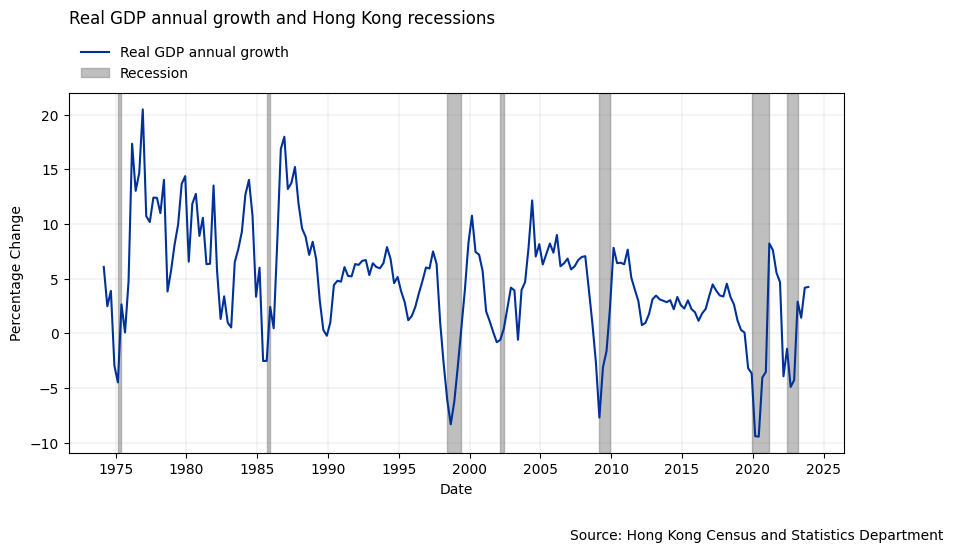

In [21]:
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Now plot your charts with the recession periods highlighted
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(df['date'], df['real_GDP_yoy'], label='Real GDP annual growth', color='#003199')
# Use the `pad` argument to add some space between the title and the plot
ax2.set_title('Real GDP annual growth and Hong Kong recessions', pad=50, loc='left')
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage Change')

# Shade the periods of recession
for start, end in zip(recession_starts, recession_ends):
    ax2.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.5)

# Create a patch for the legend representing recessions
recession_patch = mpatches.Patch(color='grey', alpha=0.5, label='Recession')

# Set major ticks on the x-axis to 5 years intervals
ax2.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Get handles and labels for the legend from the plot
handles, labels = ax2.get_legend_handles_labels()
# Add the recession patch to the handles for the legend
handles.append(recession_patch)
labels.append('Recession')

# Adjust the figure to fit the legend and the title
plt.subplots_adjust(top=0.75, bottom=0.15)

# Use fig.legend() to place the legend below the title and to the left
# Adjust the bbox_to_anchor y-value to lower the legend
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.125, 0.85), frameon=False, ncol=1)

# Add source to the chart
source_text = "Source: Hong Kong Census and Statistics Department"
fig.text(1, 0, source_text, ha='right', va='bottom')

plt.show()

Show the table of dates for the recession periods. 

In [22]:
# Initialize the columns for recession start and end dates with NaN
df['recession_start'] = pd.NaT
df['recession_end'] = pd.NaT

# We will use a flag to mark the ongoing recession status
in_recession = False

# Loop through the DataFrame to identify the start and end dates
for i in range(1, len(df)):
    # Check for the start of a recession
    if not in_recession and df.loc[i-1, 'real_GDP_yoy'] < 0 and df.loc[i, 'real_GDP_yoy'] < 0:
        df.at[i, 'recession_start'] = df.loc[i, 'date']
        in_recession = True
    # Check for the end of a recession
    elif in_recession and df.loc[i-1, 'real_GDP_yoy'] >= 0 and df.loc[i, 'real_GDP_yoy'] >= 0:
        df.at[i-1, 'recession_end'] = df.loc[i-1, 'date']
        in_recession = False

# Handling the case where the last period in the data is still in a recession
if in_recession:
    df.at[len(df)-1, 'recession_end'] = df.loc[len(df)-1, 'date']

# Print the rows where recessions start or end for verification
print(df.dropna(subset=['recession_start', 'recession_end'], how='all')[['date', 'recession_start', 'recession_end']])

          date recession_start recession_end
8   1975-03-01      1975-03-01           NaT
9   1975-06-01             NaT    1975-06-01
50  1985-09-01      1985-09-01           NaT
51  1985-12-01             NaT    1985-12-01
101 1998-06-01      1998-06-01           NaT
105 1999-06-01             NaT    1999-06-01
116 2002-03-01      2002-03-01           NaT
117 2002-06-01             NaT    2002-06-01
144 2009-03-01      2009-03-01           NaT
147 2009-12-01             NaT    2009-12-01
187 2019-12-01      2019-12-01           NaT
192 2021-03-01             NaT    2021-03-01
197 2022-06-01      2022-06-01           NaT
200 2023-03-01             NaT    2023-03-01
